In [63]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
sys.path.append('../../graph-conv')
sys.path.append('../../../ecg/v4')

import numpy as np

import pandas as pd

import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import (f1_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score)

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from pysmiles import read_smiles

from graph import SpectralGCN

from ecg.datasets import Dataloader
from ecg.train_utils import (check_sampling_status, 
                             update_weighted_sampling, 
                             SampleLossStorage)
from ecg.valid_utils import (plot_prob_dists, get_prob_thresh, 
                             print_report, plot_confusion_matrix, 
                             plot_roc_curve, 
                             plot_specificity_sensitivity_curve)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('../data/B3DB_classification.tsv', sep='\t')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO.            7807 non-null   int64  
 1   compound_name  6698 non-null   object 
 2   IUPAC_name     6170 non-null   object 
 3   SMILES         7807 non-null   object 
 4   CID            6170 non-null   float64
 5   logBB          1058 non-null   float64
 6   BBB+/BBB-      7807 non-null   object 
 7   Inchi          7807 non-null   object 
 8   threshold      3621 non-null   float64
 9   reference      7807 non-null   object 
 10  group          7807 non-null   object 
 11  comments       18 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 732.0+ KB
None


,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN
3,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,CCNC(=NCCSCc1ncccc1Br)NC#N,14022517.0,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,NaN,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,NaN
4,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,18595497.0,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,NaN,R25|,A,NaN


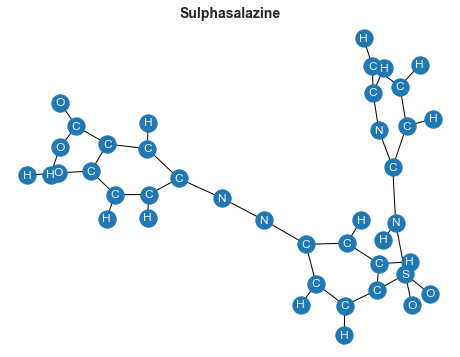

In [3]:
np.random.seed(345)
idx = 0
smiles = df.loc[idx, 'SMILES']
mol = read_smiles(smiles, explicit_hydrogen=True)

plt.figure(figsize=(8, 6))
plt.title(df.loc[idx, 'compound_name'].title(), fontsize=14, fontweight='bold')
nx.draw(mol, labels=dict(mol.nodes(data='element')), with_labels=True, font_color='whitesmoke')

In [4]:
def get_adj_mat(mol):
    try:
        A = nx.adjacency_matrix(mol).toarray()
    except AttributeError:
        A = np.nan
    return A

def get_elems(mol):
    try:
        elems = list(dict(mol.nodes(data='element')).values())
    except AttributeError:
        elems = np.nan
    return elems

def get_BBB(BBB):
    parse_dict = {'BBB-': 0, 'BBB+': 1}
    p = parse_dict[BBB]
    return p

mols = df['SMILES'].apply(read_smiles)
adj_mat = mols.apply(get_adj_mat).tolist()
elems = mols.apply(get_elems).tolist()
permeable = df['BBB+/BBB-'].apply(get_BBB).tolist()

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical in

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereoc

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical in

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that 

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains ste

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains s

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical i

E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information,

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains ster

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereoch

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemi

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereoche

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains st

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, whic

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochem

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical in

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains s

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereoch

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains st

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inf

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stere

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inf

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemica

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical informati

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information tha

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information th

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is sp

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical informatio

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inf

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereoch

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereo

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" co

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical 

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information t

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information t

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stere

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical inf

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereo

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical informati

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information t

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochem

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochem

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical infor

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[N@+]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inf

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information tha

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information tha

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical i

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[N@@+]" contains stereochemical information that will be discarded.
Atom "[N@+]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemica

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical in

E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.


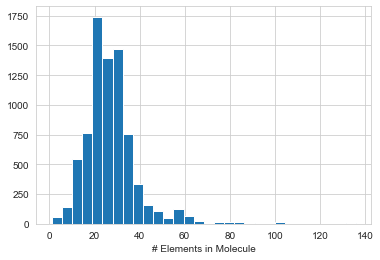

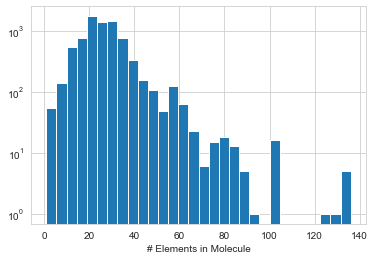

In [5]:
num_elems = np.array(list(map(lambda elems_i: len(elems_i), elems)))

plt.hist(num_elems, bins=30)
plt.xlabel('# Elements in Molecule')
plt.show()

plt.hist(num_elems, bins=30)
plt.xlabel('# Elements in Molecule')
plt.yscale('log')
plt.show()

In [6]:
N = num_elems.max()
N

136

In [7]:
max_len = 60

num_elems_cut = np.array(list(map(lambda elems_i: len(elems_i) > max_len, elems)))
num_elems_cut.mean()

0.0187011656205969

In [8]:
vocab = []
for elems_i in elems:
    vocab.extend(elems_i)
    
vocab = ['UNK'] + sorted(set(vocab))

vocab2int = {v: i for i, v in enumerate(vocab, start=1)}
int2vocab = {i: v for v, i in vocab2int.items()}

vocab

['UNK',
 'Ar',
 'B',
 'Br',
 'C',
 'Cl',
 'F',
 'I',
 'Kr',
 'Li',
 'N',
 'Ne',
 'O',
 'P',
 'S',
 'Si',
 'Xe']

In [9]:
PADDING_IDX = 0

X = np.stack([list(map(lambda e: vocab2int[e], elems_i)) + (N-len(elems_i))*[PADDING_IDX] for elems_i in elems])
X = torch.from_numpy(X[:, :max_len]).long()
X.size()

torch.Size([7807, 60])

In [10]:
def pad(arr, n):
    padded = float(PADDING_IDX)*np.ones((n, n))
    padded[:len(arr), :len(arr)] = arr
    return padded

A = np.stack([pad(adj_mat_i, N) for adj_mat_i in adj_mat])
A = torch.from_numpy(A[:, :max_len, :max_len]).float()
A.size()

torch.Size([7807, 60, 60])

In [11]:
Y = torch.LongTensor(permeable)
Y.size()

torch.Size([7807])

In [12]:
class TensorDataset(Dataset):

    def __init__(self,
                 A,
                 X,
                 Y,
                 weighted_sampling=False,
                 transform=None):
        super(TensorDataset, self).__init__()

        self.A = A
        self.X = X
        self.Y = Y
        self.weighted_sampling = weighted_sampling
        self.transform = transform
        
        self.initial_weight_ = 1000.0
        self._init_weighted_sampling()

    def __getitem__(self, idx):
        a = self.A[idx]
        x = self.X[idx]
        y = self.Y[idx]

        if self.transform is not None:
            x = self.transform(x)

        return a, x, y, idx

    def _init_weighted_sampling(self):
        if self.weighted_sampling:
            self.weight_dict = {}
            self.sampling_counter = {'count': 0}
            for idx in range(self.__len__()):
                self.weight_dict[idx] = self.initial_weight_
                self.sampling_counter[idx] = 0

    def __len__(self):
        return len(self.Y)

In [13]:
valid_size = 0.1

A_train, A_valid, X_train, X_valid, Y_train, Y_valid = train_test_split(A, X, Y, 
                                                                        stratify=Y.numpy().ravel(),
                                                                        test_size=valid_size,
                                                                        random_state=42)

A_train.size(), A_valid.size()

(torch.Size([7026, 60, 60]), torch.Size([781, 60, 60]))

In [64]:
weighted_sampling = False
batch_size = 128

p_unk = 0.5
n_max = 2
max_ratio = 0.1
def transform(x):
    if np.random.rand() < p_unk:
        mask = x.numpy() != PADDING_IDX
        indices = np.arange(max_len)[mask]
        np.random.shuffle(indices)
        n = np.random.randint(n_max-1) + 1
        if n / len(x) <= max_ratio:
            idx = indices[:n]
            if isinstance(idx, int):
                idx = [idx]
            for i in idx:
                x[i] = vocab2int['UNK']
    return x

dataset = TensorDataset(A, X, Y, weighted_sampling=weighted_sampling, transform=None)
train_dataset = TensorDataset(A_train, X_train, Y_train, weighted_sampling=weighted_sampling, transform=None)
valid_dataset = TensorDataset(A_valid, X_valid, Y_valid)

dataloader = Dataloader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)
trainloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
validloader = Dataloader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [65]:
torch.manual_seed(42)

In [66]:
embedding_dim = 32
embedding = nn.Embedding(len(vocab)+1, embedding_dim, padding_idx=0)
embedding

Embedding(18, 32, padding_idx=0)

In [67]:
model_params = {
    'in_features': embedding_dim,
    'hidden_features': [256, 128],
    'hidden_layers': [3, 3],
    'hidden_dim': None,
    'out_features': None,
    'norm': True,
    'residual': True,
    'expand': 2,
    'downsample': True,
    'activation': 'gelu',
    'squeeze_excitation': 16,
    'seq_len': max_len,
    'pooling': False,
    'flatten': False,
    'seed': 42
}    

gcnn = SpectralGCN(**model_params)
gcnn

SpectralGCN(
  (layers): ModuleList(
    (0): ModuleList(
      (0): GraphConv(in_features=32, out_features=256, bias=False)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): GELU()
    )
    (1): GraphResBlock(
      (graph_conv): GraphConv(in_features=256, out_features=512, bias=False)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation): GELU()
      (proj): Linear(in_features=512, out_features=256, bias=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (squeeze_excitation): SEUnit(
        (avg_pool): AdaptiveAvgPool1d(output_size=(1,))
        (squeeze): Conv1d(60, 3, kernel_size=(1,), stride=(1,))
        (activation): GELU()
        (excite): Conv1d(3, 60, kernel_size=(1,), stride=(1,))
        (sigmoid): Sigmoid()
      )
    )
    (2): GraphResBlock(
      (graph_conv): GraphConv(in_features=256, out_features=512, bias=False)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affi

In [68]:
d_model = model_params['hidden_features'][-1]
size = (1, 1, d_model)
cls_token = nn.Parameter(torch.randn(*size))
cls_token.size()

torch.Size([1, 1, 128])

In [69]:
dim_feedforward = 4 * d_model
nhead = 8
dropout = 0.1
activation = 'gelu'
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model, 
                                           nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout, 
                                           activation=activation, 
                                           batch_first=True)
transformer_enc = nn.TransformerEncoder(encoder_layer, num_layers)
transformer_enc

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=

In [70]:
classifier = nn.Linear(d_model, 2)
classifier

Linear(in_features=128, out_features=2, bias=True)

In [71]:
def feed_forward(a, x, return_features=False):
    x_embed = embedding(x)
    gcnn_out = gcnn(a, x_embed)
    enc_in = torch.cat([cls_token.expand(gcnn_out.size(0), -1, -1), gcnn_out], dim=1)
    src_key_padding_mask = torch.zeros(enc_in.size()[:2]) != 0
    src_key_padding_mask[:, 1:] = x == 0
    enc_out = transformer_enc(enc_in, src_key_padding_mask=src_key_padding_mask)
    cls_in = enc_out[:, 0]
    out = classifier(cls_in)
    if return_features:
        return out, cls_in
    return out

In [72]:
a, x, y, idx = iter(dataloader).next()

with torch.no_grad():
    out = feed_forward(a, x)
out.size()

torch.Size([128, 2])

In [73]:
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(permeable), 
                                     y=permeable)
class_weights = torch.from_numpy(class_weights).float()
class_weights

tensor([1.3692, 0.7876])

In [74]:
lr = 1e-4
weight_decay = 1e-5

params = list(embedding.parameters()) \
    + list(gcnn.parameters()) \
    + [cls_token] \
    + list(transformer_enc.parameters()) \
    + list(classifier.parameters())
optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
optimizer.zero_grad()

In [75]:
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

In [76]:
num_epochs = 15

data_iter = iter(trainloader)

storage = SampleLossStorage()
train_losses = []
train_scores = []
valid_losses = []
valid_scores = []

update_every = 1
sampling_kwargs = {
    'min_clip': 5,
    'max_clip': 95,
    'min_max_scaling': True,
    'eps': 1.0, 
    'topk_errors': 20
}

i_iter = 0
epoch_iters = range(len(trainloader))

embedding.train()
gcnn.train()
transformer_enc.train()
classifier.train()

for epoch in range(1, num_epochs+1):
    sample_losses_train = []
    ys_train = []
    preds_train = []
    for _ in tqdm(epoch_iters, desc=f'Epoch {epoch}', leave=False):
        _, sampled = check_sampling_status(trainloader)
        if sampled:
            criterion = nn.CrossEntropyLoss(
                weight=None, reduction='none')
            
        a, x, y, idx = data_iter.next()
        i_iter += 1
        
        out = feed_forward(a, x)
        sample_loss = criterion(out, y)
        loss = sample_loss.sum()
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(
            params, max_norm=1.0, norm_type=2.0)
        optimizer.step()        
        
        sample_losses_train.extend(
            sample_loss.squeeze().detach().numpy().tolist())
        ys_train.extend(
            y.squeeze().numpy().tolist())
        preds_train.extend(
            out.argmax(dim=1).detach().numpy().tolist())
        
        if trainloader.dataset.weighted_sampling:
            storage.add(idx, sample_loss.squeeze())
        
            if i_iter % update_every == 0:
                sampling_kwargs['print_stats'] = False
                trainloader = update_weighted_sampling(trainloaderdataloader, 
                                                      storage, 
                                                      **sampling_kwargs)

                data_iter = iter(trainloader)
                storage.reset()
    
    train_loss = np.mean(sample_losses_train)
    train_losses.append(train_loss)
    
    train_score = f1_score(ys_train, preds_train, average='macro')
    train_scores.append(train_score)
    
    # Validation
    
    embedding.eval()
    gcnn.eval()
    transformer_enc.eval()
    classifier.eval()
    
    sample_losses_valid = []
    ys_valid = []
    preds_valid = []
    for a, x, y, _ in tqdm(validloader, desc='Validation', leave=False):
        with torch.no_grad():
            out = feed_forward(a, x)
            sample_loss = criterion(out, y)

            sample_losses_valid.extend(
                sample_loss.squeeze().detach().numpy().tolist())
            ys_valid.extend(
                y.squeeze().numpy().tolist())
            preds_valid.extend(
                out.argmax(dim=1).detach().numpy().tolist())
            
    valid_loss = np.mean(sample_losses_valid)
    valid_losses.append(valid_loss)
    
    valid_score = f1_score(ys_valid, preds_valid, average='macro')
    valid_scores.append(valid_score)
        
    embedding.train()
    gcnn.train()
    transformer_enc.train()
    classifier.train()
    
    # Validation
    
    print(f'EPOCH {epoch} - CE Loss: {train_loss:.4f} | F1 Score: {train_score:.3f} | CE Loss (Validation): {valid_loss:.4f} | F1 Score (Validation): {valid_score:.3f}')
    if sampled:
        print()
        sampling_kwargs['print_stats'] = True
        _ = update_weighted_sampling(trainloader, 
                                     storage, 
                                     **sampling_kwargs)
        
    if not trainloader.dataset.weighted_sampling:
        data_iter = iter(trainloader)

EPOCH 1 - CE Loss: 0.5885 | F1 Score: 0.679 | CE Loss (Validation): 0.5215 | F1 Score (Validation): 0.765


EPOCH 2 - CE Loss: 0.5018 | F1 Score: 0.760 | CE Loss (Validation): 0.4731 | F1 Score (Validation): 0.767


EPOCH 3 - CE Loss: 0.4833 | F1 Score: 0.763 | CE Loss (Validation): 0.4972 | F1 Score (Validation): 0.725


EPOCH 4 - CE Loss: 0.4735 | F1 Score: 0.769 | CE Loss (Validation): 0.4486 | F1 Score (Validation): 0.782


EPOCH 5 - CE Loss: 0.4552 | F1 Score: 0.778 | CE Loss (Validation): 0.4339 | F1 Score (Validation): 0.805


EPOCH 6 - CE Loss: 0.4506 | F1 Score: 0.783 | CE Loss (Validation): 0.4283 | F1 Score (Validation): 0.801


EPOCH 7 - CE Loss: 0.4433 | F1 Score: 0.784 | CE Loss (Validation): 0.4330 | F1 Score (Validation): 0.782


EPOCH 8 - CE Loss: 0.4304 | F1 Score: 0.792 | CE Loss (Validation): 0.4204 | F1 Score (Validation): 0.803


EPOCH 9 - CE Loss: 0.4243 | F1 Score: 0.792 | CE Loss (Validation): 0.4281 | F1 Score (Validation): 0.791


EPOCH 10 - CE Loss: 0.4243 | F1 Score: 0.802 | CE Loss (Validation): 0.4230 | F1 Score (Validation): 0.774


EPOCH 11 - CE Loss: 0.4139 | F1 Score: 0.801 | CE Loss (Validation): 0.4053 | F1 Score (Validation): 0.804


EPOCH 12 - CE Loss: 0.4040 | F1 Score: 0.808 | CE Loss (Validation): 0.4157 | F1 Score (Validation): 0.792


EPOCH 13 - CE Loss: 0.3976 | F1 Score: 0.813 | CE Loss (Validation): 0.3917 | F1 Score (Validation): 0.808


EPOCH 14 - CE Loss: 0.3966 | F1 Score: 0.811 | CE Loss (Validation): 0.4071 | F1 Score (Validation): 0.777


EPOCH 15 - CE Loss: 0.3827 | F1 Score: 0.827 | CE Loss (Validation): 0.3921 | F1 Score (Validation): 0.810


In [77]:
if False:
    num_epochs = 15

    data_iter = iter(dataloader)

    storage = SampleLossStorage()
    losses = []
    scores = []

    update_every = 1
    sampling_kwargs = {
        'min_clip': 5,
        'max_clip': 95,
        'min_max_scaling': True,
        'eps': 1.0, 
        'topk_errors': 20
    }

    i_iter = 0
    epoch_iters = range(len(dataloader))

    embedding.train()
    gcnn.train()
    transformer_enc.train()
    classifier.train()

    for epoch in range(1, num_epochs+1):
        sample_losses = []
        ys = []
        preds = []
        for _ in tqdm(epoch_iters, desc=f'Epoch {epoch}', leave=False):
            _, sampled = check_sampling_status(dataloader)
            if sampled:
                criterion = nn.CrossEntropyLoss(
                    weight=None, reduction='none')

            a, x, y, idx = data_iter.next()
            i_iter += 1

            out = feed_forward(a, x)
            sample_loss = criterion(out, y)
            loss = sample_loss.sum()

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(
                params, max_norm=1.0, norm_type=2.0)
            optimizer.step()        

            sample_losses.extend(
                sample_loss.squeeze().detach().numpy().tolist())
            ys.extend(
                y.squeeze().numpy().tolist())
            preds.extend(
                out.argmax(dim=1).detach().numpy().tolist())

            if dataloader.dataset.weighted_sampling:
                storage.add(idx, sample_loss.squeeze())

                if i_iter % update_every == 0:
                    sampling_kwargs['print_stats'] = False
                    dataloader = update_weighted_sampling(dataloader, 
                                                          storage, 
                                                          **sampling_kwargs)

                    data_iter = iter(dataloader)
                    storage.reset()

        loss = np.mean(sample_losses)
        losses.append(loss)

        score = f1_score(ys, preds, average='macro')
        scores.append(score)

        print(f'Epoch {epoch} - CE Loss: {loss:.4f} | F1 Score: {score:.3f}')
        if sampled:
            print()
            sampling_kwargs['print_stats'] = True
            _ = update_weighted_sampling(dataloader, 
                                         storage, 
                                         **sampling_kwargs)

        if not dataloader.dataset.weighted_sampling:
            data_iter = iter(dataloader)

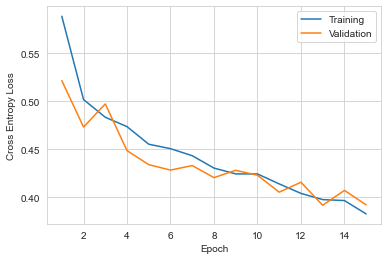

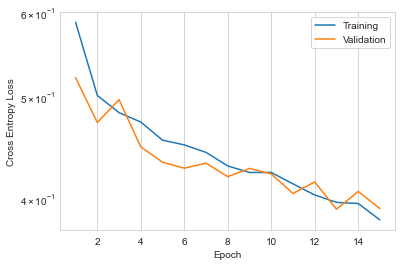

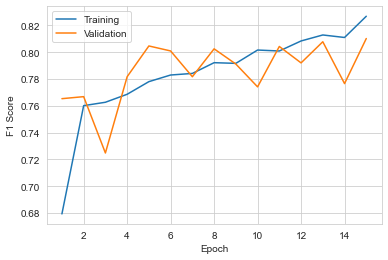

In [78]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

plt.plot(range(1, len(train_losses)+1), train_losses, label='Training')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(range(1, len(train_scores)+1), train_scores, label='Training')
plt.plot(range(1, len(valid_scores)+1), valid_scores, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [79]:
if False:
    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.show()

    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.yscale('log')
    plt.show()

    plt.plot(range(1, len(scores)+1), scores)
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.show()

In [80]:
embedding.eval()
gcnn.eval()
transformer_enc.eval()
classifier.eval()
with torch.no_grad():
    features = []
    y_true = []
    y_pred = []
    for a, x, y, idx in tqdm(validloader):
        out, feats = feed_forward(a, x, return_features=True)
        features.extend(feats.numpy().tolist())
        y_true.extend(y.squeeze().numpy().tolist())
        y_pred.extend(F.softmax(out, dim=1)[:, 1].numpy().tolist())

features = np.array(features)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
target_names = ['BBB-', 'BBB+']

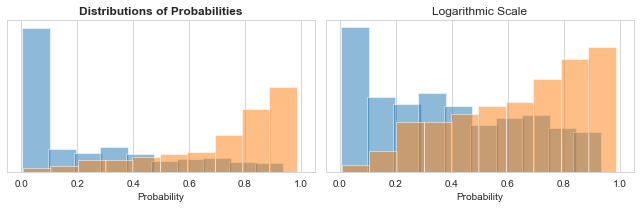

In [81]:
plot_prob_dists(y_true, y_pred, target_names)

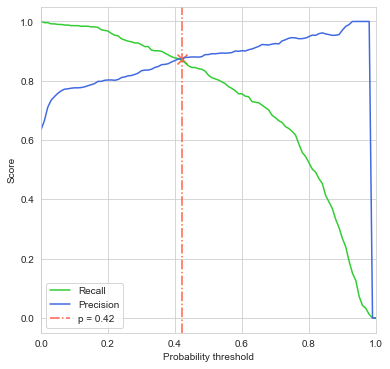

In [82]:
p_thresh = get_prob_thresh(y_true, y_pred)

In [83]:
print_report(y_true, y_pred, target_names, p_thresh=p_thresh)

              precision    recall  f1-score   support

        BBB-       0.77      0.78      0.78       285
        BBB+       0.87      0.87      0.87       496

    accuracy                           0.84       781
   macro avg       0.82      0.83      0.82       781
weighted avg       0.84      0.84      0.84       781



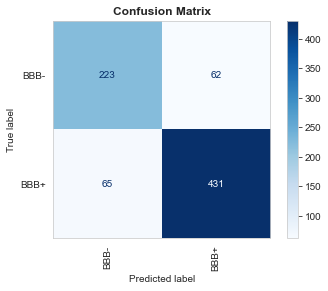

In [84]:
plot_confusion_matrix(y_true, y_pred, target_names, p_thresh=p_thresh)

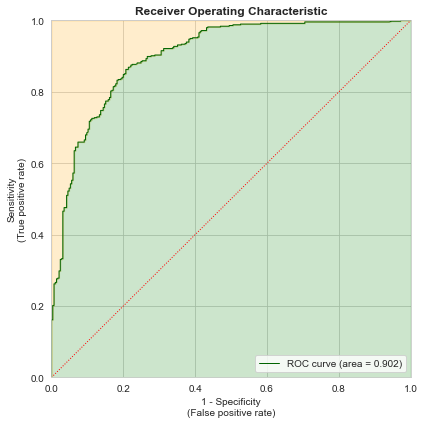

In [85]:
plot_roc_curve(y_true, y_pred)

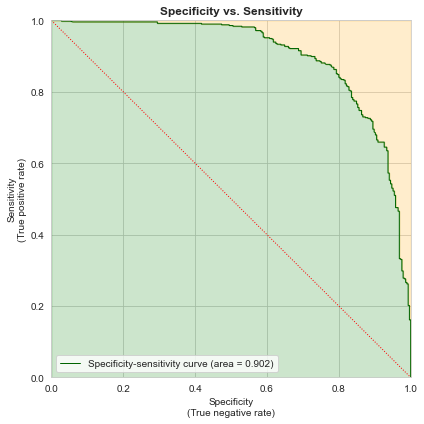

In [86]:
plot_specificity_sensitivity_curve(y_true, y_pred)

In [87]:
save = input('Save? [y/n]')

if save == 'y':
    embedding.eval()
    gcnn.eval()
    transformer_enc.eval()
    classifier.eval()
    with torch.no_grad():
        features = []
        y_true = []
        for a, x, y, idx in tqdm(dataloader, leave=False):
            _, feats = feed_forward(a, x, return_features=True)
            features.extend(feats.numpy().tolist())
            y_true.extend(y.squeeze().numpy().tolist())

    features = np.array(features)
    y_true = np.array(y_true)
    target_names = ['BBB-', 'BBB+']
    
    np.savez('b3db-features.npz', data=features, target=y_true, target_names=target_names)
    np.savez('../../self-organizing-map/data/b3db-features.npz', 
             data=features, target=y_true, target_names=target_names)

    weights = {
        'embedding': embedding.state_dict(),
        'gcnn': gcnn.state_dict(),
        'cls_token': cls_token,
        'transformer_enc': transformer_enc.state_dict(),
        'classifier': classifier.state_dict()
    }
    torch.save(weights, 'b3db-weights.pt')
    print('Saved!')

Save? [y/n]y


Saved!
